In [1]:
#Importamos Librerias Necesarias
#Importamos Librerias Necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error
from math import sqrt
from sklearn import svm
from sklearn.model_selection import ParameterGrid
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from joblib import Parallel, delayed,cpu_count
import optuna

c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Volvemos a cargar el conjunto de datos
df = pd.read_csv('BBDD_Insurance.csv',sep=';',decimal=',')

In [3]:
#Volvemos a cargar el conjunto de datos
df = pd.read_csv('BBDD_Insurance.csv',sep=';',decimal=',')
df = df.drop_duplicates()
#Encoding
le = LabelEncoder()
df['Sexo'] = le.fit_transform(df['Sexo'])
df['Fumador'] = le.fit_transform(df['Fumador'])
df['Region EEUU'] = le.fit_transform(df['Region EEUU'])

In [4]:
# División de los datos de entrenamiento y test

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns="Gastos"),
    df['Gastos'],
    test_size=0.25,
    random_state=42
)
print(f"Tamaño conjunto entrenamiento: {X_train.shape[0]}")
print(f"Tamaño conjunto test: {X_test.shape[0]}")

#Creacion del Modelo
modelo = RandomForestRegressor(
    n_estimators = 10,
    criterion = 'squared_error',
    max_depth = None,
    max_features = 1,
    oob_score = False,
    n_jobs = -1,
    random_state = 123
)
#Entrenamiento del modelo
modelo.fit(X_train, y_train)

Tamaño conjunto entrenamiento: 1003
Tamaño conjunto test: 335


RandomForestRegressor(max_features=1, n_estimators=10, n_jobs=-1,
                      random_state=123)

In [5]:
#Error de test del modelo inicial
predicciones= modelo.predict(X=X_test)
rmse = root_mean_squared_error(y_true=y_test,y_pred=predicciones)
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 7091.967238462728


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Optimal value of n_estimators: 196


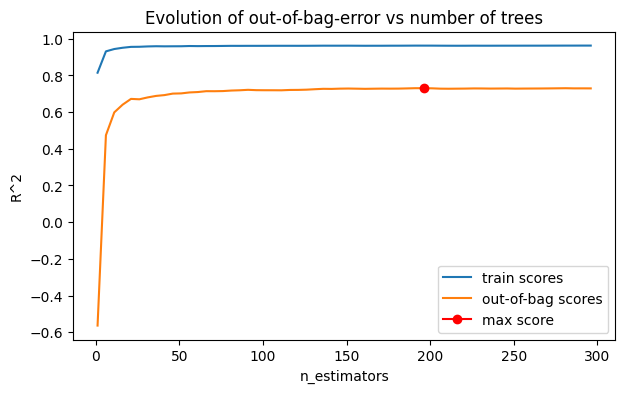

In [6]:
##Busqueda del numero de arboles óptimo
train_scores = []
oob_scores = []  # corrected variable name

# Values to evaluate
estimator_range = range(1, 300, 5)

# Loop to train a model with each value of n_estimators and extract its training error and out-of-bag error
for n_estimators in estimator_range:
    modelo = RandomForestRegressor(
        n_estimators=n_estimators,
        criterion='squared_error',
        max_depth=None,
        max_features=1,
        oob_score=True,  # changed to True to calculate OOB score
        n_jobs=-1,
        random_state=123
    )
    modelo.fit(X_train, y_train)
    train_scores.append(modelo.score(X_train, y_train))
    oob_scores.append(modelo.oob_score_)  # corrected variable name

# Plot showing the evolution of the errors
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores), marker='o', color="red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolution of out-of-bag-error vs number of trees")
plt.legend()
print(f"Optimal value of n_estimators: {estimator_range[np.argmax(oob_scores)]}")


Optimal value of n_estimators: 331


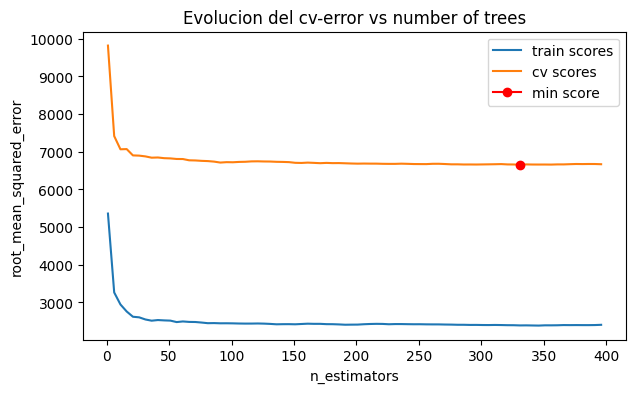

In [7]:
#Validación empleando k-cross-validation y neg_root_mean_squared_error

# Function to calculate root mean squared error
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

train_scores = []
cv_scores = []
#Se determina el rango
estimator_range = range(1, 400, 5)
#Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
for n_estimators in estimator_range:
    modelo = RandomForestRegressor(
        n_estimators=n_estimators,
        criterion='squared_error',
        max_depth=None,
        max_features=1,
        oob_score=False, 
        n_jobs=-1,
        random_state=123
    )
    # Error de entrenamiento
    modelo.fit(X_train, y_train)
    predicciones = modelo.predict(X=X_train)
    rmse = root_mean_squared_error(
        y_true=y_train,
        y_pred=predicciones,
    )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
        estimator=modelo,
        X=X_train,
        y=y_train,
        scoring='neg_root_mean_squared_error',
        cv=5
    )    
    cv_scores.append(-1 * scores.mean())

# Plot showing the evolution of the errors
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, cv_scores, label="cv scores")
ax.plot(estimator_range[np.argmin(cv_scores)], min(cv_scores), marker='o', color="red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("n_estimators")
ax.set_title("Evolucion del cv-error vs number of trees")
plt.legend()
print(f"Optimal value of n_estimators: {estimator_range[np.argmin(cv_scores)]}")


Optimal value of max_features: 3


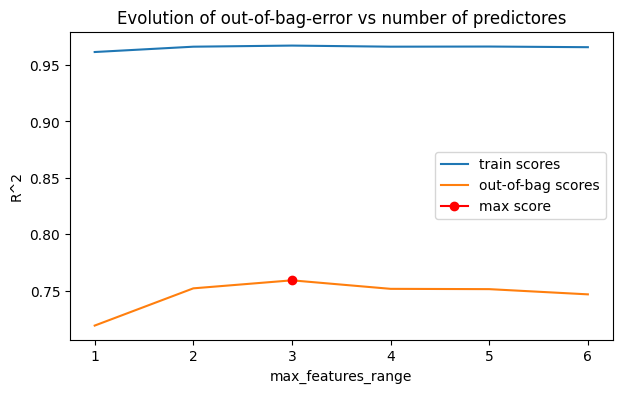

In [8]:
#Max Features
#Out-of-Bag error
train_scores = []
oob_scores = [] 

# Values to evaluate
max_features_range = range(1,X_train.shape[1] + 1, 1)

# Loop to train a model with each value of n_estimators and extract its training error and out-of-bag error
for max_features in max_features_range:
    modelo = RandomForestRegressor(
        n_estimators=100,
        criterion='squared_error',
        max_depth=None,
        max_features=max_features,
        oob_score=True,  # changed to True to calculate OOB score
        n_jobs=-1,
        random_state=123
    )
    modelo.fit(X_train, y_train)
    train_scores.append(modelo.score(X_train, y_train))
    oob_scores.append(modelo.oob_score_)  # corrected variable name

# Plot showing the evolution of the errors
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, oob_scores, label="out-of-bag scores")
ax.plot(max_features_range[np.argmax(oob_scores)], max(oob_scores), marker='o', color="red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("max_features_range")
ax.set_title("Evolution of out-of-bag-error vs number of predictores")
plt.legend()
print(f"Optimal value of max_features: {max_features_range[np.argmax(oob_scores)]}")

Optimal value of max_features: 3


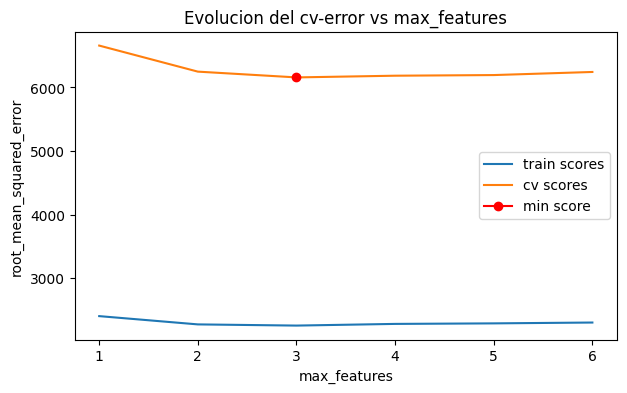

In [9]:
# Function to calculate root mean squared error
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Define ranges for max_features
max_features_range = range(1, 7)

train_scores = []
cv_scores = []

for max_features in max_features_range:
    modelo = RandomForestRegressor(
        n_estimators=300,  # Choose an appropriate number
        criterion='squared_error',
        max_depth=None,    # You can also vary max_depth if needed
        max_features=max_features,
        oob_score=False, 
        n_jobs=-1,
        random_state=123
    )
    # Error de entrenamiento
    modelo.fit(X_train, y_train)
    predicciones = modelo.predict(X=X_train)
    rmse = root_mean_squared_error(
        y_true=y_train,
        y_pred=predicciones,
    )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
        estimator=modelo,
        X=X_train,
        y=y_train,
        scoring='neg_root_mean_squared_error',
        cv=5
    )    
    cv_scores.append(-1 * scores.mean())

# Plot showing the evolution of the errors
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, cv_scores, label="cv scores")
ax.plot(max_features_range[np.argmin(cv_scores)], min(cv_scores), marker='o', color="red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("max_features")
ax.set_title("Evolucion del cv-error vs max_features")
plt.legend()
print(f"Optimal value of max_features: {max_features_range[np.argmin(cv_scores)]}")

In [10]:
# Grid de hiperparámetros evaluados
param_grid = ParameterGrid({
    'n_estimators': [350],
    'max_features': [3, 5, 7],
    'max_depth': [None, 3, 10, 20]  # Valores enteros
})

# Convertir los valores de max_depth a enteros
param_grid = [{'n_estimators': params['n_estimators'],
               'max_features': params['max_features'],
               'max_depth': int(params['max_depth']) if params['max_depth'] is not None else None}
              for params in param_grid]

# Loop para ajustar un modelo con cada combinación de hiperparámetros
resultados = {'params': [], 'oob_r2': []}

for params in param_grid:
    modelo = RandomForestRegressor(
        n_estimators=params['n_estimators'],
        max_features=params['max_features'],
        max_depth=params['max_depth'],  # Mantener el valor como está
        oob_score=True,
        n_jobs=-1,
        random_state=123
    )
    modelo.fit(X_train, y_train)
    resultados['params'].append(params)
    resultados['oob_r2'].append(modelo.oob_score_)
    print(f"Modelo: {modelo}")

# Resultados
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns='params')
resultados = resultados.sort_values('oob_r2', ascending=False)
resultados.head(4)

Modelo: RandomForestRegressor(max_features=3, n_estimators=350, n_jobs=-1,
                      oob_score=True, random_state=123)
Modelo: RandomForestRegressor(max_features=5, n_estimators=350, n_jobs=-1,
                      oob_score=True, random_state=123)
Modelo: RandomForestRegressor(max_features=7, n_estimators=350, n_jobs=-1,
                      oob_score=True, random_state=123)
Modelo: RandomForestRegressor(max_depth=3, max_features=3, n_estimators=350, n_jobs=-1,
                      oob_score=True, random_state=123)
Modelo: RandomForestRegressor(max_depth=3, max_features=5, n_estimators=350, n_jobs=-1,
                      oob_score=True, random_state=123)
Modelo: RandomForestRegressor(max_depth=3, max_features=7, n_estimators=350, n_jobs=-1,
                      oob_score=True, random_state=123)
Modelo: RandomForestRegressor(max_depth=10, max_features=3, n_estimators=350, n_jobs=-1,
                      oob_score=True, random_state=123)
Modelo: RandomForestRegressor(

,oob_r2,n_estimators,max_features,max_depth
4,0.767079,350.0,5.0,3.0
5,0.766047,350.0,7.0,3.0
6,0.761679,350.0,3.0,10.0
9,0.761262,350.0,3.0,20.0


In [11]:
#Creacion del Modelo Final
modelo_final = RandomForestRegressor(
    n_estimators = 350,
    criterion = 'squared_error',
    max_depth = 3,
    max_features = 5,
    oob_score = False,
    n_jobs = -1,
    random_state = 123)

#Entrenamiento del modelo
modelo_final.fit(X_train, y_train)
predicciones = modelo_final.predict(X=X_test)
rmse = root_mean_squared_error(y_true = y_test, y_pred=predicciones)
print (f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 5303.0564434692205


In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Predicciones del modelo en el conjunto de prueba
predicciones = modelo_final.predict(X_test)

# Calcular el MAE
mae = mean_absolute_error(y_test, predicciones)
print(f'El MAE en el conjunto de prueba es: {mae}')

# Calcular el MSE
mse = mean_squared_error(y_test, predicciones)
print(f'El MSE en el conjunto de prueba es: {mse}')

# Calcular el MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test, predicciones)
print(f'El MAPE en el conjunto de prueba es: {mape}')


El MAE en el conjunto de prueba es: 3399.6508298732933
El MSE en el conjunto de prueba es: 28122407.64262043
El MAPE en el conjunto de prueba es: 39.3685301975599


Modelo: RandomForestRegressor(max_features=3, n_estimators=350, n_jobs=-1,
                      oob_score=True, random_state=123)
Modelo: RandomForestRegressor(max_features=5, n_estimators=350, n_jobs=-1,
                      oob_score=True, random_state=123)
Modelo: RandomForestRegressor(max_features=7, n_estimators=350, n_jobs=-1,
                      oob_score=True, random_state=123)
Modelo: RandomForestRegressor(max_depth=3, max_features=3, n_estimators=350, n_jobs=-1,
                      oob_score=True, random_state=123)
Modelo: RandomForestRegressor(max_depth=3, max_features=5, n_estimators=350, n_jobs=-1,
                      oob_score=True, random_state=123)
Modelo: RandomForestRegressor(max_depth=3, max_features=7, n_estimators=350, n_jobs=-1,
                      oob_score=True, random_state=123)
Modelo: RandomForestRegressor(max_depth=10, max_features=3, n_estimators=350, n_jobs=-1,
                      oob_score=True, random_state=123)
Modelo: RandomForestRegressor(

C:\Users\HP\AppData\Local\Temp\ipykernel_17380\2746109363.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances,palette='viridis')


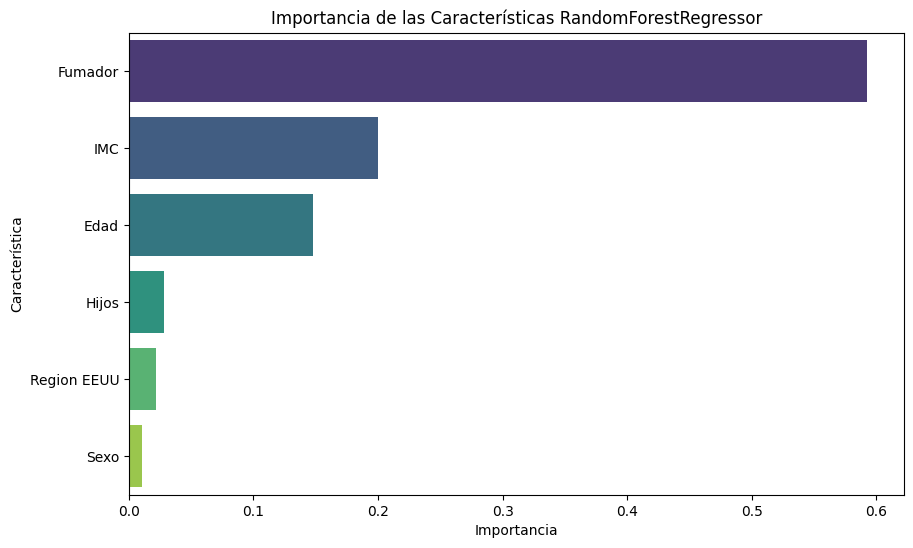

In [13]:
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Grid de hiperparámetros evaluados
param_grid = ParameterGrid({
    'n_estimators': [350],
    'max_features': [3, 5, 7],
    'max_depth': [None, 3, 10, 20]  # Valores enteros
})

# Convertir los valores de max_depth a enteros
param_grid = [{'n_estimators': params['n_estimators'],
               'max_features': params['max_features'],
               'max_depth': int(params['max_depth']) if params['max_depth'] is not None else None}
              for params in param_grid]

# Inicializar un diccionario para almacenar los resultados
resultados = {'params': [], 'oob_r2': []}

# Loop para ajustar un modelo con cada combinación de hiperparámetros
for params in param_grid:
    modelo = RandomForestRegressor(
        n_estimators=params['n_estimators'],
        max_features=params['max_features'],
        max_depth=params['max_depth'],  # Mantener el valor como está
        oob_score=True,
        n_jobs=-1,
        random_state=123
    )
    modelo.fit(X_train, y_train)  # Entrenar el modelo
    resultados['params'].append(params)
    resultados['oob_r2'].append(modelo.oob_score_)
    print(f"Modelo: {modelo}")

# Convertir los resultados a un DataFrame
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns='params')

# Características más importantes después de ajustar el modelo
importances = modelo.feature_importances_
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Graficar las características más importantes en un gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances,palette='viridis')
plt.title('Importancia de las Características RandomForestRegressor')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.show()


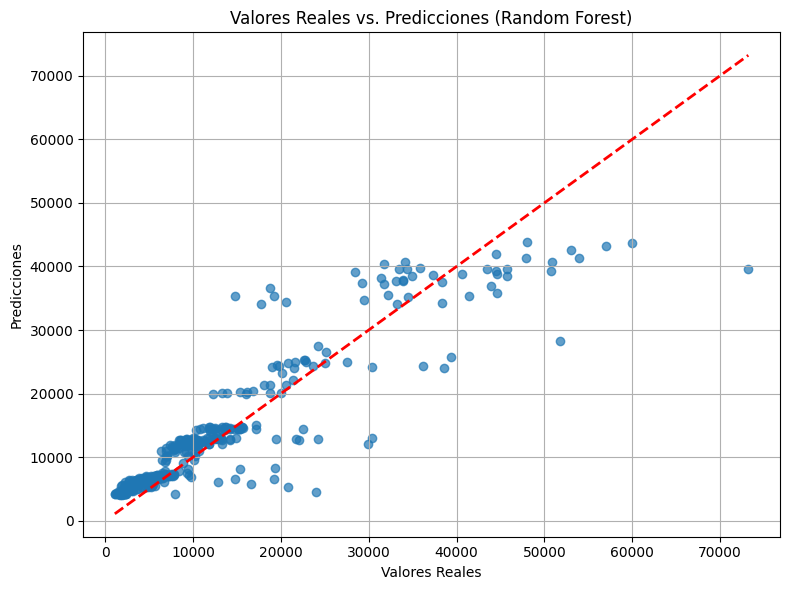

In [14]:

# Graficar los valores reales vs predicciones
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predicciones, alpha=0.7)
plt.plot(np.linspace(min(y_test), max(y_test), 100), np.linspace(min(y_test), max(y_test), 100), color='red', linestyle='--', linewidth=2)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Valores Reales vs. Predicciones (Random Forest)")
plt.grid(True)
plt.tight_layout()
plt.show()


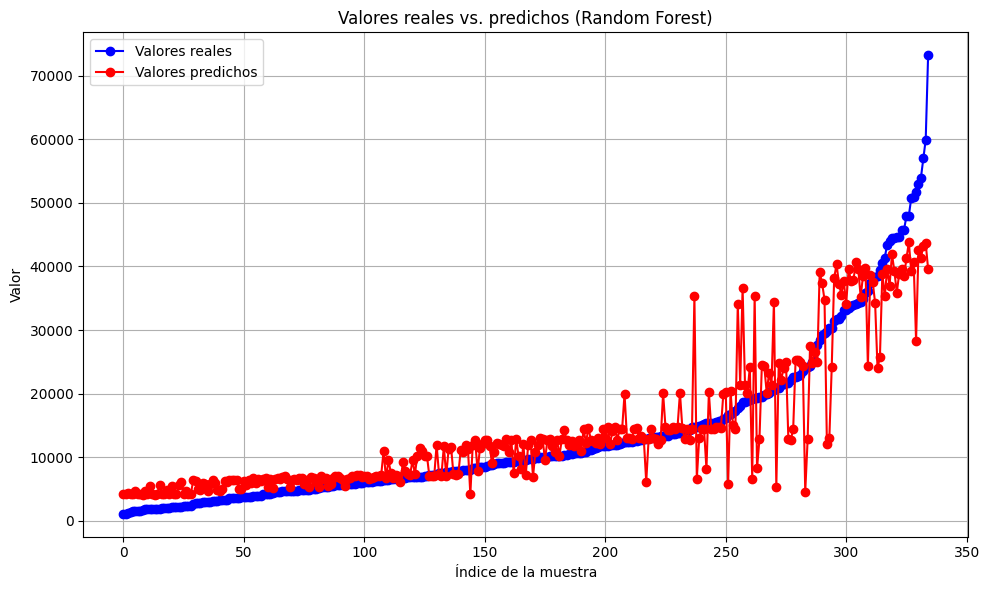

In [15]:

# Crear un array con el índice de las muestras
indices = np.arange(len(y_test))

# Ordenar los valores reales y predichos por los valores reales
sorted_indices = np.argsort(y_test)

# Graficar los valores reales y predichos
plt.figure(figsize=(10, 6))
plt.plot(indices, y_test.iloc[sorted_indices], 'b-', marker='o', label='Valores reales')
plt.plot(indices, predicciones[sorted_indices], 'r-', marker='o', label='Valores predichos')
plt.xlabel('Índice de la muestra')
plt.ylabel('Valor')
plt.title('Valores reales vs. predichos (Random Forest)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Grid de hiperparámetros evaluados

param_grid = {'n_estimators': [150],
              'max_features': [5, 7, 9],
              'max_depth'   : [None, 3, 10, 20]
             }

# Búsqueda por grid search con validación cruzada
grid = GridSearchCV(
            estimator  = RandomForestRegressor(random_state = 123),
            param_grid = param_grid,
            scoring    = 'neg_root_mean_squared_error',
            n_jobs     = cpu_count() - 1,
            cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123), 
            refit      = True,
            verbose    = 0,
            return_train_score = True
       )

grid.fit(X=X_train, y=y_train)